# PD PRS Generation

This notebook is designed to generate PRS(Polygenic Risk Score) of Parkinson Disease with LDpred Algorithm.

## Author

Yingnan Han

# Set up notebook environments

## Install software

Before executing the code in this notebook, run the notebook `Py3 - Setup` and restart your kernel (`Kernel` > `Restart` in the Jupyter menu).

## Load libraries

In [1]:
# Use the os package to interact with the environment
import os

# Use the sys package to interact with stderr
import sys

# Use the FireCloud API to interact with the workspace
from firecloud import api as fapi

# Use Pandas for tabular data
import pandas as pd

# Use StringIO for working with file contents
from io import StringIO

# Enable IPython to display matplotlib graphs.
import matplotlib.pyplot as plt
%matplotlib inline

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.core.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

import scipy as sp

import h5py

import seaborn as sns

import random

import numpy as np

from pyplink import PyPlink

import glob

## Create utility functions

In [2]:
# Utility routine for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}', file=sys.stderr)
    !$command
    
def shell_return(command):
    print(f'Executing: {command}', file=sys.stderr)
    output = !$command
    return '\n'.join(output)

# Utility routine for printing a query before executing it
def bq_query(query):
    print(f'Executing: {query}', file=sys.stderr)
    return pd.read_gbq(query, project_id=BILLING_PROJECT_ID, dialect='standard')

# Utility routines for reading files from Google Cloud Storage
def gcs_read_file(path):
    """Return the contents of a file in GCS"""
    contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
    return '\n'.join(contents)
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))
    
# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_gcs(description, link_text, gcs_path):
    url = '{}?{}'.format(
        os.path.join('https://console.cloud.google.com/storage/browser',
                     gcs_path.replace("gs://","")),
        urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

    display_html_link(description, link_text, url)
    
# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_bq(description, link_text, bq_dataset, bq_table=None):
    project, dataset = bq_dataset.split('.', 1)
    if bq_table:
        page_params = {'page': 'table', 'p': project, 'd': dataset, 't': bq_table}
    else:
        page_params = {'page': 'dataset', 'p': project, 'd': dataset}
    
    url = '{}?{}'.format(
        'https://console.cloud.google.com/bigquery',
        urllib.parse.urlencode(page_params))

    display_html_link(description, link_text, url)

## Set up notebook globals

Set up references to the WGS data in Cloud Storage and BigQuery

This code gets path information from the workspace so that we can update the workspace metadata when new versions of data are published and then just re-run the notebooks in the workspace.

To pin to a particular version, you can replace all the block below with a few lines, setting:
```
  GS_WGS_SAMPLES_PATH = 'gs://amp-pd-genomics/samples/wgs'
  GS_WGS_SAMPLES_GATK_PATH = os.path.join(GS_WGS_SAMPLES_PATH, 'gatk')

  GS_WGS_RELEASE_PATH = 'gs://amp-pd-genomics/releases/<your-release>/wgs'
  GS_WGS_RELEASE_GATK_PATH = os.path.join(GS_WGS_RELEASE_PATH, 'gatk')

  BQ_WGS_RELEASE_DATASET = 'amp-pd-research:<your-release>_genomics'
  BQ_WGS_RELEASE_DATASET_STD = BQ_WGS_RELEASE_DATASET.replace(':', '.')
  ```

In [3]:
data_version = '2019_v1release_1015'
notebook = 'PD_PRS'

BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE_NAME = os.environ['WORKSPACE_NAME']

WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})
#WGS data on Google Cloud and BigQuery
GS_WGS_SAMPLES_PATH = 'gs://amp-pd-genomics/samples/wgs'
GS_WGS_SAMPLES_GATK_PATH = os.path.join(GS_WGS_SAMPLES_PATH, 'gatk')
GS_WGS_RELEASE_PATH = 'gs://amp-pd-genomics/releases/'+data_version+'/wgs'
GS_WGS_RELEASE_GATK_PATH = os.path.join(GS_WGS_RELEASE_PATH, 'gatk')
GS_WGS_RELEASE_PLINK_PATH = os.path.join(GS_WGS_RELEASE_PATH, 'plink')
BQ_WGS_RELEASE_DATASET = 'amp-pd-research:'+data_version+'_genomics'
BQ_WGS_RELEASE_DATASET_STD = BQ_WGS_RELEASE_DATASET.replace(':', '.')


#Clinical data on Goole BigQuery and Google Cloud
BQ_TIER1_RELEASE_DATASET = 'amp-pd-research:'+data_version
BQ_TIER1_RELEASE_DATASET_STD = BQ_TIER1_RELEASE_DATASET.replace(':', '.')
GS_TIER1_RELEASE_PATH = 'gs://amp-pd-data/releases/'+data_version
GS_CLINICAL_RELEASE_PATH = f'{GS_TIER1_RELEASE_PATH}/clinical'

#get the name of workspace bucket
Bucket = os.environ['WORKSPACE_BUCKET']
print('My Workspace Bucket is '+Bucket)

My Workspace Bucket is gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658


Go to the GUI console to create a folder for data input/output from this notebook 

In [4]:
link_to_cloud_console_gcs('View in Cloud Console:', 'My Bucket', Bucket)

# PRS Generation

## Load Data

### Download Plink files of samples from AMPPD

In [4]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls {GS_WGS_RELEASE_PLINK_PATH}/bfile')

Executing: gsutil -u fc-amp-pd-alpha ls gs://amp-pd-genomics/releases/2019_v1release_1015/wgs/plink/bfile


gs://amp-pd-genomics/releases/2019_v1release_1015/wgs/plink/bfile/README.txt
gs://amp-pd-genomics/releases/2019_v1release_1015/wgs/plink/bfile/all_vcfs.bed
gs://amp-pd-genomics/releases/2019_v1release_1015/wgs/plink/bfile/all_vcfs.bim
gs://amp-pd-genomics/releases/2019_v1release_1015/wgs/plink/bfile/all_vcfs.fam
gs://amp-pd-genomics/releases/2019_v1release_1015/wgs/plink/bfile/all_vcfs.log


In [5]:
#Download plink files of samples in AMPPD from Google Cloud
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp {GS_WGS_RELEASE_PLINK_PATH}/bfile/all_vcfs.bed .')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp {GS_WGS_RELEASE_PLINK_PATH}/bfile/all_vcfs.bim .')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} cp {GS_WGS_RELEASE_PLINK_PATH}/bfile/all_vcfs.fam .')

Executing: gsutil -u fc-amp-pd-alpha cp gs://amp-pd-genomics/releases/2019_v1release_1015/wgs/plink/bfile/all_vcfs.fam .


Copying gs://amp-pd-genomics/releases/2019_v1release_1015/wgs/plink/bfile/all_vcfs.fam...
/ [1 files][ 93.8 KiB/ 93.8 KiB]                                                
Operation completed over 1 objects/93.8 KiB.                                     


### Download PD GWAS Summary Statistics and Reference data

In [4]:
#Download GWAS Summary stats of PD from Bucket 
shell_do(f'gsutil cp {Bucket}/{notebook}_{data_version}/MN_complete_summstat.txt .')

Executing: gsutil cp gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/MN_complete_summstat.txt .


Copying gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/MN_complete_summstat.txt...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [1 files][  1.2 GiB/  1.2 GiB]      0.0 B/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [ ]:
#Download GWAS Summary stats of PD in FinnGen from Bucket 
shell_do(f'gsutil cp {Bucket}/{notebook}_{data_version}/finngen_stat_R4.txt .')

Executing: gsutil cp gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/finngen_stat_R4.txt .


Copying gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/finngen_stat_R4.txt...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").



In [5]:
#Download Reference Data from Bucket (1000Genomes)
shell_do(f'gsutil cp {Bucket}/{notebook}_{data_version}/filt_reference.bed .')
shell_do(f'gsutil cp {Bucket}/{notebook}_{data_version}/filt_reference.bim .')
shell_do(f'gsutil cp {Bucket}/{notebook}_{data_version}/filt_reference.fam .')


Executing: gsutil cp gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/filt_reference.bed .


Copying gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/filt_reference.bed...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [1 files][  1.1 GiB/  1.1 GiB]                                                
Operation completed over 1 objects/1.1 GiB.                                      


Executing: gsutil cp gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/filt_reference.bim .


Copying gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/filt_reference.bim...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][267.5 MiB/267.5 MiB]                                                
Operation completed over 1 objects/267.5 MiB.                                    


Executing: gsutil cp gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/filt_reference.fam .


Copying gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/filt_reference.fam...
/ [1 files][ 12.3 KiB/ 12.3 KiB]                                                
Operation completed over 1 objects/12.3 KiB.                                     


### Download fixed python files for LDpred

Fix some bugs in LDpred algorithm, and replace the original file in ldpred folder

In [15]:
#debug and replace ldpred run.py/validate.py/coord_genotypes.py with new file

shell_do(f'gsutil cp {Bucket}/{notebook}_{data_version}/run.py .')
!rm ldpred/ldpred/run.py
!mv run.py ldpred
!ls ldpred/ldpred

Executing: gsutil cp gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/run.py .


Copying gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/run.py...
/ [1 files][ 24.2 KiB/ 24.2 KiB]                                                
Operation completed over 1 objects/24.2 KiB.                                     
coord_genotypes.py  LDpred_inf.py	 plinkfiles.py	sum_stats_parsers.py
__init__.py	    LD_pruning_thres.py  reference	util.py
LDpred_fast.py	    ld.py		 reporting.py	validate.py
LDpred_gibbs.py     __main__.py		 run.py


In [5]:
shell_do(f'gsutil cp {Bucket}/{notebook}_{data_version}/sum_stats_parsers.py .')
!rm ldpred/ldpred/sum_stats_parsers.py
!mv sum_stats_parsers.py ldpred/ldpred
!ls ldpred/ldpred

Executing: gsutil cp gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/sum_stats_parsers.py .


Copying gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/sum_stats_parsers.py...
/ [1 files][ 20.6 KiB/ 20.6 KiB]                                                
Operation completed over 1 objects/20.6 KiB.                                     
coord_genotypes.py  LDpred_inf.py	 plinkfiles.py	sum_stats_parsers.py
__init__.py	    LD_pruning_thres.py  __pycache__	util.py
LDpred_fast.py	    ld.py		 reference	validate.py
LDpred_gibbs.py     __main__.py		 reporting.py


In [6]:
shell_do(f'gsutil cp {Bucket}/{notebook}_{data_version}/coord_genotypes.py .')
!rm ldpred/ldpred/coord_genotypes.py
!mv coord_genotypes.py ldpred/ldpred
!ls ldpred/ldpred

Executing: gsutil cp gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/coord_genotypes.py .


Copying gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/coord_genotypes.py...
/ [1 files][ 28.1 KiB/ 28.1 KiB]                                                
Operation completed over 1 objects/28.1 KiB.                                     
coord_genotypes.py  LDpred_inf.py	 plinkfiles.py	sum_stats_parsers.py
__init__.py	    LD_pruning_thres.py  reference	util.py
LDpred_fast.py	    ld.py		 reporting.py	validate.py
LDpred_gibbs.py     __main__.py		 run.py


In [5]:
shell_do(f'gsutil cp {Bucket}/{notebook}_{data_version}/validate.py .')
!rm ldpred/ldpred/validate.py
!mv validate.py ldpred/ldpred
!ls ldpred/ldpred

Executing: gsutil cp gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/validate.py .


Copying gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/validate.py...
/ [1 files][ 37.5 KiB/ 37.5 KiB]                                                
Operation completed over 1 objects/37.5 KiB.                                     
coord_genotypes.py  LDpred_inf.py	 plinkfiles.py	sum_stats_parsers.py
__init__.py	    LD_pruning_thres.py  reference	util.py
LDpred_fast.py	    ld.py		 reporting.py	validate.py
LDpred_gibbs.py     __main__.py		 run.py


In [15]:
shell_do(f'gsutil cp {Bucket}/{notebook}_{data_version}/LDpred_fast.py .')
!rm ldpred/ldpred/LDpred_fast.py
!mv LDpred_fast.py ldpred/ldpred
!ls ldpred/ldpred

Executing: gsutil cp gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/LDpred_fast.py .


Copying gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/LDpred_fast.py...
/ [1 files][  9.0 KiB/  9.0 KiB]                                                
Operation completed over 1 objects/9.0 KiB.                                      
coord_genotypes.py  LDpred_inf.py	 plinkfiles.py	sum_stats_parsers.py
__init__.py	    LD_pruning_thres.py  __pycache__	util.py
LDpred_fast.py	    ld.py		 reference	validate.py
LDpred_gibbs.py     __main__.py		 reporting.py


In [5]:
shell_do(f'gsutil cp {Bucket}/{notebook}_{data_version}/ld.py .')
!rm ldpred/ldpred/ld.py
!mv ld.py ldpred/ldpred
!ls ldpred/ldpred

Executing: gsutil cp gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/ld.py .


Copying gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/ld.py...
/ [1 files][ 16.8 KiB/ 16.8 KiB]                                                
Operation completed over 1 objects/16.8 KiB.                                     
coord_genotypes.py  LDpred_inf.py	 plinkfiles.py	sum_stats_parsers.py
__init__.py	    LD_pruning_thres.py  __pycache__	util.py
LDpred_fast.py	    ld.py		 reference	validate.py
LDpred_gibbs.py     __main__.py		 reporting.py


## Preprocess on summary statistics

In LDpred version 1.0.11, we don't need to make each variant have same sample size in GWAS study

In [5]:
new_idstat = pd.read_csv('MN_complete_summstat.txt',sep='\t')
#new_idstat['N'] = new_idstat['N_cases']+new_idstat['N_controls']
new_idstat.shape

(17481741, 12)

## LDpred Algorithm

### coordinating summary stats and reference dataset

In [9]:
!python ldpred/run.py coord --help

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

=============================== LDpred v. 1.0.11 ===============================

usage: LDpred coord [-h] --gf GF --ssf SSF [--N N] --out OUT [--vbim VBIM]
                    [--vgf VGF] [--only-hm3] [--ilist ILIST]
                    [--skip-coordination] [--eff_type {OR,LOGOR,BLUP,LINREG}]
                    [--match-genomic-pos] [--maf MAF]
                    [--max-freq-discrep MAX_FREQ_DISCREP]
                    [--ssf-format {PGC,GIANT,CUSTOM,LDPRED,STANDARD,BASIC}]
                    [--rs RS] [--A1 A1] [--A2 A2] [--pos POS] [--info INFO]
                    [--chr CHR] [--reffreq REFFREQ] [--pval PVAL] [--eff EFF]
                    [--se SE] [--ncol NCOL] [--case-freq 

In Mike Nalls et al.2019 summary stats, A1 is effect allele, A2 is non-effect allele, in LDpred algorithm Version 1.0.11, A1 refers to effect allele, A2 refers to non-effect allele.

In [8]:
!python ldpred/run.py --debug coord --gf filt_reference --ssf MN_complete_summstat.txt --out MN_beta --eff_type LINREG --ssf-format CUSTOM --rs rsid_37 --A1 A1 --A2 A2 --pos pos --chr chr --pval p --eff b --se se --ncol N --max-freq-discrep 1

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

=============================== LDpred v. 1.0.11 ===============================

Parsed parameters:
{'ldpred_action': 'coord', 'debug': True, 'gf': 'filt_reference', 'ssf': 'MN_complete_summstat.txt', 'N': None, 'out': 'MN_beta', 'vbim': None, 'vgf': None, 'only_hm3': False, 'ilist': None, 'skip_coordination': False, 'eff_type': 'LINREG', 'match_genomic_pos': False, 'maf': 0.01, 'max_freq_discrep': 1.0, 'ssf_format': 'CUSTOM', 'rs': 'rsid_37', 'A1': 'A1', 'A2': 'A2', 'pos': 'pos', 'info': 'INFO', 'chr': 'chr', 'reffreq': 'MAF', 'pval': 'p', 'eff': 'b', 'se': 'se', 'ncol': 'N', 'case_freq': None, 'control_freq': None, 'case_n': None, 'control_n': None, 'z_from_se': False}
Parsing bim fi

### gibbs sampling for calculating weights

In [8]:
!python ldpred/run.py gibbs -h

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

=============================== LDpred v. 1.0.11 ===============================

usage: LDpred gibbs [-h] --cf CF --ldr LDR --ldf LDF --out OUT [--f F [F ...]]
                    [--N N] [--n-iter N_ITER] [--n-burn-in N_BURN_IN]
                    [--h2 H2] [--use-gw-h2] [--no-ld-compression]
                    [--hickle-ld] [--incl-long-range-ld]

optional arguments:
  -h, --help            show this help message and exit
  --cf CF               Coordinated file (generated using ldpred coord).
                        Should be a (full path) filename.
  --ldr LDR             LD radius. An integer number which denotes the number
                        of SNPs on each side of the foc

In [12]:
!python ldpred/run.py --debug gibbs --cf MN_beta --ldr 2177 --ldf snp_weight_MN --out snp_weight_MN --f 0.03 0.01 0.001 0.003

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

=============================== LDpred v. 1.0.11 ===============================

Parsed parameters:
{'ldpred_action': 'gibbs', 'debug': True, 'cf': 'MN_beta', 'ldr': 2177, 'ldf': 'snp_weight_MN', 'out': 'snp_weight_MN', 'f': [0.03, 0.01, 0.001, 0.003], 'N': None, 'n_iter': 100, 'n_burn_in': 10, 'h2': None, 'use_gw_h2': False, 'no_ld_compression': False, 'hickle_ld': False, 'incl_long_range_ld': False}
Calculating LD information w. radius 2177
Calculating LD for chromosome chrom_1
Calculating LD for chromosome chrom_10
Calculating LD for chromosome chrom_11
Calculating LD for chromosome chrom_12
Calculating LD for chromosome chrom_13
Calculating LD for chromosome chrom_14
Calculating LD

Gibbs sampling can not be converged and take super long time to run, we perform LDpred-fast Joel Mefford's sparsified BLUP prediction instead

In [9]:
!python ldpred/run.py --debug fast --cf MN_beta --ldr 2177 --ldf snp_weight_MN --out fast_snp_weight_MN 

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

=============================== LDpred v. 1.0.11 ===============================

Parsed parameters:
{'ldpred_action': 'fast', 'debug': True, 'cf': 'MN_beta', 'ldr': 2177, 'ldf': 'snp_weight_MN', 'out': 'fast_snp_weight_MN', 'f': [1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001], 'N': None, 'h2': None, 'use_gw_h2': False, 'no_ld_compression': False, 'hickle_ld': False}
Calculating LD information w. radius 2177
Calculating LD for chromosome chrom_1
Calculating LD for chromosome chrom_10
Calculating LD for chromosome chrom_11
Calculating LD for chromosome chrom_12
Calculating LD for chromosome chrom_13
Calculating LD for chromosome chrom_14
Calculating LD for chromosome chrom_15
Calculating LD for 

### overlapped variants in AMPPD and Finngen

Find overlapped variants between AMPPD genotypes and Finngen genotypes, prepare to concatenate AMPPD samples and Finngen samples

In [10]:
def overlap_file(weight_file, finngen_df,amppd_file='all_vcfs'):
    #weights file from LDpred algorithm
    new_weight = pd.read_csv(weight_file,sep='    ')
    new_weight['chr'] = new_weight['chrom'].apply(lambda x: x[6:])
    new_weight['chr'] = np.array(new_weight['chr']).astype(np.int64)
    
    #merge weights file with Finngen summary stats based on SNP ID
    merge = new_weight.merge(finngen_df,left_on='sid',right_on='rsids',how='inner')
    print('%d SNPs in weight file'%(new_weight.shape[0]))
    print('After merging weight file with Finngen file, %d SNPs remained'%(merge.shape[0]))
    
    plfile = PyPlink(amppd_file)
    amppd = plfile.get_bim()
    print('%d SNPs in AMPPD file'%(amppd.shape[0]))
    overlap = merge.merge(amppd,left_on='sid',right_index=True,how='inner')
    print('After merging with AMPPD file, %d SNPs remained'%(overlap.shape[0]))
    t= overlap.apply(lambda x: ((x['nt1']==x['ref'])&(x['nt2']==x['alt']))or((x['nt2']==x['ref'])&(x['nt1']==x['alt'])),axis=1)
    Tru = overlap.loc[t==True]
    Fal = overlap.loc[t==False]
    #Tru.shape
    oppo = {"A":"T","T":"A","C":"G","G":"C","*":"*"}
    y = Fal.loc[Fal.apply(lambda x: ((''.join([oppo[i] for i in x['nt1']])==x['ref'])&(''.join([oppo[i] for i in x['nt2']])==x['alt']))or((''.join([oppo[i] for i in x['nt2']])==x['ref'])&(''.join([oppo[i] for i in x['nt1']])==x['alt'])),axis=1)]
    t = y.apply(lambda x: ((x['a1']==x['ref'])&(x['a2']==x['alt']))or((x['a2']==x['ref'])&(x['a1']==x['alt']))or((''.join([oppo[i] for i in x['a1']])==x['ref'])&(''.join([oppo[i] for i in x['a2']])==x['alt']))or((''.join([oppo[i] for i in x['a2']])==x['ref'])&(''.join([oppo[i] for i in x['a1']])==x['alt'])),axis=1)
    Truz = Tru.loc[Tru.apply(lambda x:((x['a1']==x['ref'])&(x['a2']==x['alt']))or((x['a2']==x['ref'])&(x['a1']==x['alt']))or((''.join([oppo[i] for i in x['a1']])==x['ref'])&(''.join([oppo[i] for i in x['a2']])==x['alt']))or((''.join([oppo[i] for i in x['a2']])==x['ref'])&(''.join([oppo[i] for i in x['a1']])==x['alt'])),axis=1)]
    final = pd.concat([Truz,y.loc[t==True]])
    print('After filtering, %d overlapped SNPs within weight file, AMPPD file and Finngen file'%(final.shape[0]))
    
    final = final.loc[:,['chrom_x', 'pos_x', 'sid', 'nt1', 'nt2', 'raw_beta', ' ldpred_beta']]
    final.rename(columns={'chrom_x':'chrom','pos_x':'pos',' ldpred_beta':'ldpred_beta'},inplace=True)
    return final
    
    
    

In [11]:


#summary stats from Finngen
pdsg6 = pd.read_csv('finngen_stat_R4.txt',sep='\t',dtype={'rsids':str})
pdsg6.dropna(axis=0,inplace=True)
pdsg6.rename(columns={'#chrom':'chr'},inplace=True)
pdsg6 = pdsg6.loc[pdsg6.chr!='X']
pdsg6 = pdsg6.astype({'chr':'int'})



/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
for thres in ['p1.0000e-02','p3.0000e-02','p1.0000e-03','p3.0000e-03','p1.0000e-01','p3.0000e-01','p1.0000e+00']:
    print('Now analyzing %s'%thres)
    weight_file = 'fast_snp_weight_MN_LDpred_fast_'+thres+'.txt'
    final = overlap_file(weight_file=weight_file,finngen_df=pdsg6,amppd_file='all_vcfs')
    update_name = 'overlap_finngen_LDpred_'+thres+'.txt'
    final.to_csv(update_name,sep=' ',index=False)

Now analyzing p1.0000e-02


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


6531339 SNPs in weight file
After merging weight file with Finngen file, 6290172 SNPs remained
28791969 SNPs in AMPPD file
After merging with AMPPD file, 6241559 SNPs remained
After filtering, 6233374 overlapped SNPs within weight file, AMPPD file and Finngen file
Now analyzing p3.0000e-02
6531339 SNPs in weight file
After merging weight file with Finngen file, 6290172 SNPs remained
28791969 SNPs in AMPPD file
After merging with AMPPD file, 6241559 SNPs remained
After filtering, 6233374 overlapped SNPs within weight file, AMPPD file and Finngen file
Now analyzing p1.0000e-03
6531339 SNPs in weight file
After merging weight file with Finngen file, 6290172 SNPs remained
28791969 SNPs in AMPPD file
After merging with AMPPD file, 6241559 SNPs remained
After filtering, 6233374 overlapped SNPs within weight file, AMPPD file and Finngen file
Now analyzing p3.0000e-03
6531339 SNPs in weight file
After merging weight file with Finngen file, 6290172 SNPs remained
28791969 SNPs in AMPPD file
Afte

#### Transfer ID for FinnGen

Transfer the SNP rsid to variant_id in weight files, in order to be applied in FinnGen cohort. Because FinnGen use variant_id to label SNPs

In [13]:
def transfer_id(chrom='chr',A1='ref',A2='alt',pos = 'pos_y'):
    return ('chr'+str(chrom)+'_'+str(pos)+'_'+str(A1)+'_'+str(A2))

for file in glob.glob('overlap_finngen_LDpred_p*'):
    print(file)
    #weights file from LDpred algo
    new_weight = pd.read_csv(file,sep=' ')
    new_weight['chr'] = new_weight['chrom'].apply(lambda x: x[6:])
    new_weight['chr'] = np.array(new_weight['chr']).astype(np.int64)
    

    #merge weights file with Finngen summary stats based on SNP ID
    merge = new_weight.merge(pdsg6,left_on='sid',right_on='rsids',how='inner')
    oppo = {"A":"T","T":"A","C":"G","G":"C","*":"*"}
    
    t= merge.apply(lambda x: ((x['nt1']==x['ref'])&(x['nt2']==x['alt']))or((x['nt2']==x['ref'])&(x['nt1']==x['alt'])),axis=1)
    s = merge.loc[t==True]
    fal = merge.loc[t==False]
    y = fal.loc[fal.apply(lambda x: ((oppo[x['nt1']]==x['ref'])&(oppo[x['nt2']]==x['alt']))or((oppo[x['nt2']]==x['ref'])&(oppo[x['nt1']]==x['alt'])),axis=1)]
    y['nt1'] = y.apply(lambda x: oppo[x['nt1']],axis=1)
    y['nt2'] = y.apply(lambda x: oppo[x['nt2']],axis=1)
    final = pd.concat([s,y])
    print(final.shape)
    final = final.loc[:,['chrom', 'pos_x', 'nt1', 'nt2', 'raw_beta', 'ldpred_beta','chr_y','pos_y','ref','alt']]
    #final.rename(columns={'chrom_x':'chrom','pos_x':'pos',' ldpred_beta':'ldpred_beta'},inplace=True)
    
    final['variant_id'] = final.apply(lambda x: transfer_id(x['chr_y'],x['ref'],x['alt'],x['pos_y']),axis=1)
    final = final.loc[:,['chrom', 'pos_x', 'variant_id', 'nt1', 'nt2', 'raw_beta', 'ldpred_beta']]
    newname = 'ov'+file[7:]
    final.to_csv(newname,sep='\t',index=False)

overlap_finngen_LDpred_p3.0000e-01.txt


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(6233374, 21)
overlap_finngen_LDpred_p1.0000e+00.txt
(6233374, 21)
overlap_finngen_LDpred_p1.0000e-02.txt
(6233374, 21)
overlap_finngen_LDpred_p3.0000e-03.txt
(6233374, 21)
overlap_finngen_LDpred_p1.0000e-03.txt
(6233374, 21)
overlap_finngen_LDpred_p1.0000e-01.txt
(6233374, 21)
overlap_finngen_LDpred_p3.0000e-02.txt
(6233374, 21)


#### upload files to bucket

In [17]:
# upload file to bucket, in order to permanently save files


#shell_do(f'gsutil cp ov_finngen_LDpred* {Bucket}/{notebook}_{data_version}/')
shell_do(f'gsutil cp overlap_finngen_LDpred* {Bucket}/{notebook}_{data_version}/')

Executing: gsutil cp overlap_finngen_LDpred* gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/


Copying file://overlap_finngen_LDpred_p1.0000e+00.txt [Content-Type=text/plain]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://overlap_finngen_LDpred_p1.0000e-01.txt [Content-Type=text/plain]...
Copying file://overlap_finngen_LDpred_p1.0000e-02.txt [Content-Type=text/plain]...
Copying file://overlap_finngen_LDpred_p1.0000e-03.txt [Content-Ty

### calculating PRS

In [12]:
!python ldpred/run.py score -h

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

=============================== LDpred v. 1.0.11 ===============================

usage: LDpred score [-h] [--gf GF] --rf RF --out OUT [--pf PF]
                    [--pf-format {STANDARD,FAM,LSTANDARD}]
                    [--rf-format {LDPRED,ANY,P+T}] [--cov-file COV_FILE]
                    [--pcs-file PCS_FILE] [--split-by-chrom] [--only-score]
                    [--f F [F ...]] [--p P [P ...]] [--r2 R2 [R2 ...]]
                    [--summary-file SUMMARY_FILE]

optional arguments:
  -h, --help            show this help message and exit
  --gf GF               Validation genotype file. PLINK formatted genotypes
                        for which we want to calculate risk scores.


In [5]:
!python ldpred/run.py --debug score --gf all_vcfs --rf overlap_finngen --out newprs_overlap_MN --only-score --rf-format LDPRED --f 0.01 0.001 0.003 

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

=============================== LDpred v. 1.0.11 ===============================

Parsed parameters:
{'ldpred_action': 'score', 'debug': True, 'gf': 'all_vcfs', 'rf': 'overlap_finngen', 'out': 'newprs_overlap_MN', 'pf': None, 'pf_format': 'STANDARD', 'rf_format': 'LDPRED', 'cov_file': None, 'pcs_file': None, 'split_by_chrom': False, 'only_score': True, 'f': [0.01, 0.001, 0.003], 'p': [1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.00030000000000000003, 0.0001, 3.0000000000000004e-05, 1e-05, 1e-06, 1e-07, 1e-08], 'r2': [1, 0.2], 'summary_file': None}

Calculating LDpred risk scores using f=1.000e-02
Parsing PLINK bed file: all_vcfs
Iterating over BED file to calculate risk scores.
100.00%Numbe

### pruning and theresholding

In [2]:
!python ldpred/LDpred.py p+t -h

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

=============================== LDpred v. 1.0.6 ================================

usage: LDpred p+t [-h] --cf CF --ldr LDR --out OUT [--p P [P ...]]
                  [--r2 R2 [R2 ...]]

optional arguments:
  -h, --help        show this help message and exit
  --cf CF           Coordinated file (generated using ldpred coord). Should be
                    a (full path) filename.
  --ldr LDR         LD radius. An integer number which denotes the number of
                    SNPs on each side of the focal SNP for which LD should be
                    adjusted. A value corresponding M/3000, where M is the
                    number of SNPs in the genome is recommended
  --out OUT        

In [68]:
!python ldpred/LDpred.py score --gf all_vcfs_merged --rf snp_weight_finngen_pt --out prs_pt --only-score --rf-format P+T

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp

=============================== LDpred v. 1.0.6 ================================


Calculating P+T risk scores using p-value threshold of 3.000e-01, and r2 threshold of 0.20
^C
Traceback (most recent call last):
  File "ldpred/LDpred.py", line 300, in <module>
    main()
  File "ldpred/LDpred.py", line 293, in main
    validate.main(p_dict)
  File "/home/jupyter-user/AMP PD - Workshop_PRS/ldpred/ldpred/validate.py", line 711, in main
    rs_id_map,

## Overlapped bim file 

Select overlapped SNPs from AMPPD bim file, in order to compare with FinnGen genotypes, find the difference and make PRS computation identical for every individual from FInnGen and AMPPD

In [8]:
amppd_file = 'all_vcfs'
plfile = PyPlink(amppd_file)
amppd = plfile.get_bim()
weight = pd.read_csv('overlap_finngen_LDpred_p1.0000e+00.txt',sep=' ')
weight.shape

(6233374, 7)

In [9]:
ov_amppd = amppd.loc[weight.sid,]
ov_amppd.shape

(6233374, 5)

In [10]:
#summary stats from Finngen
pdsg6 = pd.read_csv('finngen_stat_R4.txt',sep='\t',dtype={'rsids':str})
pdsg6.dropna(axis=0,inplace=True)
pdsg6.rename(columns={'#chrom':'chr'},inplace=True)
pdsg6 = pdsg6.loc[pdsg6.chr!='X']
pdsg6 = pdsg6.astype({'chr':'int'})

merge = ov_amppd.merge(pdsg6,left_index=True,right_on='rsids',how='inner')
merge.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(6240873, 18)

In [11]:
t= merge.apply(lambda x: ((x['a1']==x['ref'])&(x['a2']==x['alt']))or((x['a2']==x['ref'])&(x['a1']==x['alt'])),axis=1)
s = merge.loc[t==True]
s.shape
fal = merge.loc[t==False]
oppo = {"A":"T","T":"A","C":"G","G":"C","*":"*"}
y = fal.loc[fal.apply(lambda x: ((oppo[x['a1']]==x['ref'])&(oppo[x['a2']]==x['alt']))or((oppo[x['a2']]==x['ref'])&(oppo[x['a1']]==x['alt'])),axis=1)]
y['a1'] = y.apply(lambda x: oppo[x['a1']],axis=1)
y['a2'] = y.apply(lambda x: oppo[x['a2']],axis=1)
final = pd.concat([s,y])
final.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(6233374, 18)

In [13]:
submerge=final.loc[:,['rsids','nearest_genes','chrom', 'pos_x',  'a1', 'a2', 'chr','pos_y','ref','alt']]
submerge.head()

,rsids,nearest_genes,chrom,pos_x,a1,a2,chr,pos_y,ref,alt
85,rs72631875,OR4F16,1,770502,A,G,1,770502,G,A
128,rs116030099,OR4F16,1,787290,C,T,1,787290,T,C
157,rs148120343,OR4F16,1,794707,C,T,1,794707,T,C
162,rs186002080,OR4F16,1,796073,A,G,1,796073,G,A
177,rs369030935,OR4F16,1,797609,T,C,1,797609,C,T


In [14]:
def transfer_id(chrom='chr',A1='ref',A2='alt',pos = 'pos_y'):
    return ('chr'+str(chrom)+'_'+str(pos)+'_'+str(A1)+'_'+str(A2))

submerge['variant_id'] = submerge.apply(lambda x: transfer_id(x['chr'],x['ref'],x['alt'],x['pos_y']),axis=1)
sub = submerge.loc[:,['rsids','nearest_genes','variant_id', 'a1','a2']]
sub.head()

,rsids,nearest_genes,variant_id,a1,a2
85,rs72631875,OR4F16,chr1_770502_G_A,A,G
128,rs116030099,OR4F16,chr1_787290_T_C,C,T
157,rs148120343,OR4F16,chr1_794707_T_C,C,T
162,rs186002080,OR4F16,chr1_796073_G_A,A,G
177,rs369030935,OR4F16,chr1_797609_C_T,T,C


In [15]:
sub.to_csv('finn_check_alle.txt',sep='\t',index=False)
shell_do(f'gsutil cp finn_check_alle.txt {Bucket}/{notebook}_{data_version}/')

Executing: gsutil cp finn_check_alle.txt gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/


Copying file://finn_check_alle.txt [Content-Type=text/plain]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1 files][237.4 MiB/237.4 MiB]                                                
Operation completed over 1 objects/237.4 MiB.                                    


## PRS exploration

Add label(case/control), age and gender to PRS files

In [5]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls {GS_TIER1_RELEASE_PATH}')

Executing: gsutil -u fc-amp-pd-alpha ls gs://amp-pd-data/releases/2019_v1release_1015


gs://amp-pd-data/releases/2019_v1release_1015/Release Notes 2019_v1release_1015.pdf
gs://amp-pd-data/releases/2019_v1release_1015/amp_pd_case_control.csv
gs://amp-pd-data/releases/2019_v1release_1015/amp_pd_participants.csv
gs://amp-pd-data/releases/2019_v1release_1015/duplicate_subjects.csv
gs://amp-pd-data/releases/2019_v1release_1015/rna_sample_inventory.csv
gs://amp-pd-data/releases/2019_v1release_1015/wgs_gatk_joint_genotyping_samples.csv
gs://amp-pd-data/releases/2019_v1release_1015/wgs_sample_inventory.csv
gs://amp-pd-data/releases/2019_v1release_1015/clinical/


In [5]:
#extract phenotypes from case_control tables
control_case = gcs_read_csv(os.path.join(GS_TIER1_RELEASE_PATH, 'amp_pd_case_control.csv'))

control_case.case_control_other_latest.value_counts()

Case       2529
Control    1476
Other       293
Name: case_control_other_latest, dtype: int64

In [9]:
demographic = gcs_read_csv(os.path.join(GS_CLINICAL_RELEASE_PATH, 'Demographics.csv'))
demographic.head()

,participant_id,GUID,visit_name,visit_month,age_at_baseline,sex,ethnicity,race,education_level_years
0,PD-PDNE299YPT,PDNE299YPT,M0,0,74,Male,Not Hispanic or Latino,White,Greater than 16 years
1,PD-PDYW828VAV,PDYW828VAV,M0,0,57,Female,Not Hispanic or Latino,White,12-16 years
2,PD-PDWV958JPG,PDWV958JPG,M0,0,68,Male,Not Hispanic or Latino,White,Greater than 16 years
3,PD-PDRF387ZV3,PDRF387ZV3,M0,0,68,Male,Not Hispanic or Latino,White,12-16 years
4,PD-PDAC268KWV,PDAC268KWV,M0,0,69,Female,Not Hispanic or Latino,White,Greater than 16 years


In [73]:
#load packages for analysis
import seaborn as sns
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_validate
import glob

In [7]:
#normalization for PRS
def zstand(row,mean,std):
    return (row-mean)/std

#merge PRS file with phenotypes, 
#prs_file: PRS file, label_file: phenotype file, 
#label_identity: if the diagnosis at baseline should be same with that at latest time 
def create_label(prs_file,label_file,label_identity=False):
    prs = pd.read_csv(prs_file,sep=',')
    control_case=label_file.loc[:,['participant_id','diagnosis_latest','case_control_other_at_baseline','case_control_other_latest']]
    merged_df = prs.merge(control_case,left_on='IID',right_on='participant_id',how='left')
    ori_n = merged_df.shape[0]
    merged_df.dropna(inplace=True)
    n = merged_df.shape[0]
    print('there are %d missing labels'%(ori_n-n))
    sub=merged_df[' PRS ']
    merged_df['norm_prs'] = sub.apply(lambda x: zstand(x,sp.mean(sub),sp.std(sub)))
    if label_identity:
        same_label = merged_df.loc[merged_df['case_control_other_at_baseline']==merged_df['case_control_other_latest']]
        diff_label = merged_df.loc[merged_df['case_control_other_at_baseline']!=merged_df['case_control_other_latest']]
        print('%d samples have different label at latest record with baseline'%diff_label.shape[0])
        return same_label,diff_label
    return merged_df

#distribution plot for PRS, merged_df: dataframe
def dist_plot(merged_df,score=' PRS ',label='case_control_other_latest'):
    sns.distplot((merged_df.loc[merged_df[label]=='Case'])[score],label='Parkinson')
    sns.distplot((merged_df.loc[merged_df[label]=='Control'])[score],label='Normal').legend()

#prevalence in different percentile
#df: dataframe, num_percentile: numbers of points you want, label: column name of phenotype 
def prevalence(df,num_percentile=10,label='case_control_other_latest'):
    relation = {'prevalence':[],'percentile':[]}
    for m in range(num_percentile):
        i = m*(100/num_percentile)
        i1 = (m+1)*(100/num_percentile)
        perc = sp.percentile(df[' PRS '],i)
    
        postperc = sp.percentile(df[' PRS '],i1)
        #print(perc,postperc)
        if i !=0:
            subdf = df.loc[((df[' PRS ']<=postperc) & (df[' PRS ']>perc))]
            #print(subdf)
        else:
            subdf = df.loc[df[' PRS ']<=postperc]
        
        print(sum(subdf['case_control_other_latest']=='Case')/sum((subdf['case_control_other_latest']=='Case')|(subdf['case_control_other_latest']=='Control')))
        if subdf.shape[0] != 0:
            relation['percentile'].append(i)
            prev = sum(subdf[label]=='Case')/subdf.shape[0]
            relation['prevalence'].append(prev)
        else:
            print('Mistake! no records in sub-dataset')
    return relation


#logistic regression to predict the probability being cases
#df: dataframe, has_ROC: if you want ROC curve to show in the return result, label: column name of phenotype
#feature: column names as features in logistic regression, metrics: evaluation metrics, test_size: size of testing data
#random_state: random_state, k-fold: k-fold cross validation
def logisticregression(df,has_ROC=True,label = 'case_control_other_latest',feature = ['norm_prs'],metrics='roc_auc', test_size=0.2,random_state=33,k_fold=5):
    if len(set(df[label]))>2:
        PD_df = df.loc[(df[label]=='Case')|(df[label]=='Control')]
        print('there are %d samples in case and control'%(PD_df.shape[0]))
    if 'logistic_class' not in PD_df.columns:
        PD_df['logistic_class'] = PD_df[label].apply(lambda x: int(x=='Case'))
    if len(feature)==1:
        X = (sp.array(PD_df[feature])).reshape(-1,1)
    else:
        X = sp.array(PD_df[feature])
    y = PD_df['logistic_class']
    train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=test_size,random_state=random_state,stratify = y)
    logis = LogisticRegression(solver = 'lbfgs')
    scores = cross_validate(logis, train_x, train_y, scoring=[metrics], cv=StratifiedKFold(n_splits=k_fold))
    avg_validatescore = sp.mean(scores['test_'+metrics])
    
    lg = logis.fit(train_x,train_y)
    y_pre = lg.predict_proba(test_x)
    pred = [y_pre[i][1] for i in range(len(y_pre))]
    test_score = roc_auc_score(test_y,pred)
    if has_ROC:
        ROC_curve(test_y,pred)
    return avg_validatescore,test_score

#plot ROC curve
def ROC_curve(test_y,ypre):
    fpr, tpr, _ = roc_curve(test_y,ypre)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='orange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()
    
#deal with missing values in features
def missing_value(df,feature_col):
    for col in feature_col:
        if df[col].dtypes=='object':
            df.loc[df[col].isna(),col] = 'Unknown'
        else:
            df.loc[df[col].isna(),col] = sp.mean(df.loc[df[col].notna(),col])
    return df

### Add label, age, gender to score files

In [10]:
for thres in ['p1.0000e-02','p1.0000e-03','p1.0000e-01','p3.0000e-02','p3.0000e-01','p3.0000e-03','p1.0000e+00']:
    prs = 'newprs_overlap_MN_LDpred_'+thres+'.txt'
    print(prs)
    #merged prs file and phenotypes file
    merged_df,diff_label = create_label(prs,control_case,label_identity=True)
    demo_merge = merged_df.merge(demographic[['participant_id','sex','age_at_baseline','race']],on='participant_id',how='left')
    print(demo_merge.shape)
    newname = 'prs_amp_'+thres+'.txt'
    demo_merge[['IID',' PRS ','case_control_other_at_baseline','sex','age_at_baseline','race']].to_csv(newname,sep='\t',index=False)

newprs_overlap_MN_LDpred_p1.0000e-02.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 10)
newprs_overlap_MN_LDpred_p1.0000e-03.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 10)
newprs_overlap_MN_LDpred_p1.0000e-01.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 10)
newprs_overlap_MN_LDpred_p3.0000e-02.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 10)
newprs_overlap_MN_LDpred_p3.0000e-01.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 10)
newprs_overlap_MN_LDpred_p3.0000e-03.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 10)
newprs_overlap_MN_LDpred_p1.0000e+00.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 10)


In [11]:
shell_do(f'gsutil cp prs_amp_* {Bucket}/{notebook}_{data_version}/')

Executing: gsutil cp prs_amp_* gs://fc-secure-2687fa72-4cc9-42c3-8a27-4a05ee9bd658/PD_PRS_2019_v1release_1015/


Copying file://prs_amp_p1.0000e+00.txt [Content-Type=text/plain]...
Copying file://prs_amp_p1.0000e-01.txt [Content-Type=text/plain]...             
Copying file://prs_amp_p1.0000e-02.txt [Content-Type=text/plain]...             
Copying file://prs_amp_p1.0000e-03.txt [Content-Type=text/plain]...             
- [4 files][521.5 KiB/521.5 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://prs_amp_p3.0000e-01.txt [Content-Type=text/plain]...
Copying file://prs_amp_p3.0000e-02.txt [Content-Type=text/plain]...             
Copying file://prs_amp_p3.0000e-03.txt [Content-Type=text/plain]...             
\ [7 files][914.7 KiB/914.7 KiB]                                                
Operation completed over 7 objects/914.7 KiB.

### Extremes of PRS

In [46]:
prs_file = 'prs_amp_p1.0000e+00.txt'
prs = pd.read_csv(prs_file,sep='\t')
mutate = pd.read_csv('amp_pd_participant_mutations.csv')
mutate = mutate[['participant_id','has_known_GBA_mutation_in_WGS','has_known_LRRK2_mutation_in_WGS','has_known_SNCA_mutation_in_WGS']]
prs = prs.merge(mutate,left_on='IID',right_on='participant_id',how='inner')

In [52]:
prs.case_control_other_at_baseline.unique()

array(['Control', 'Case', 'Other'], dtype=object)

In [53]:
prs = prs.loc[prs.case_control_other_at_baseline!="Other"]
prs = prs.loc[prs.race=="White"]

In [65]:
prs = prs.merge(gsva,on='participant_id',how='inner')

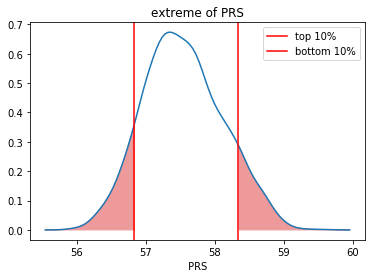

In [11]:
ax = sns.distplot(prs[' PRS '],hist=False)
kde_x, kde_y = ax.lines[0].get_data()
plt.axvline(x=np.percentile(prs[' PRS '],90),color = 'red',label = 'top 10%')
plt.axvline(x=np.percentile(prs[' PRS '],10),color = 'red',label = 'bottom 10%')
ax.fill_between(kde_x, kde_y, where=(kde_x<np.percentile(prs[' PRS '],10)) | (kde_x>np.percentile(prs[' PRS '],90)) , 
                interpolate=True, color='#EF9A9A')
plt.title('extreme of PRS')
plt.legend()

In [54]:
top = prs.loc[prs[' PRS ']>=sp.percentile(prs[' PRS '],90)]
low = prs.loc[prs[' PRS ']<=sp.percentile(prs[' PRS '],10)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.percentile is deprecated and will be removed in SciPy 2.0.0, use numpy.percentile instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.percentile is deprecated and will be removed in SciPy 2.0.0, use numpy.percentile instead
  


In [55]:
x1 = np.percentile(prs[' PRS '],90)
x2 = np.percentile(prs[' PRS '],10)
def label(x):
    if x>=x1: 
        return 'top'
    elif x<=x2: 
        return 'low'
    else: 
        return 'middle'
prs['group'] = prs[' PRS '].apply(lambda x: label(x))

In [56]:
prs['GBA'] = prs['has_known_GBA_mutation_in_WGS'].apply(lambda x: int(x=='Yes'))
prs['SNCA'] = prs['has_known_SNCA_mutation_in_WGS'].apply(lambda x: int(x=='Yes'))
prs['LRRK2'] = prs['has_known_LRRK2_mutation_in_WGS'].apply(lambda x: int(x=='Yes'))

### Visualization

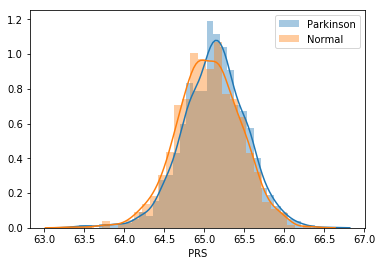

In [12]:
#distribution plot for cases and controls
ax = sns.distplot((merged_df.loc[merged_df['case_control_other_latest']=='Case'])[' PRS '],label='Parkinson')
#ax = sns.distplot((merged_df.loc[(merged_df['case_control_other_latest']=='Case')&(merged_df['has_known_GBA_mutation']=='Yes')])[' PRS '],label='Parkinson&GBA')
#ax = sns.distplot((merged_df.loc[(merged_df['case_control_other_latest']=='Case')&(merged_df['has_known_GBA_mutation']=='No')])[' PRS '],label='Parkinson&non-GBA')
ax = sns.distplot((merged_df.loc[merged_df['case_control_other_latest']=='Control'])[' PRS '],label='Normal').legend()
ax

0.5444839857651246
0.5428571428571428
0.5785714285714286
0.5392857142857143
0.6761565836298933
0.6178571428571429
0.6428571428571429
0.6607142857142857
0.6357142857142857
0.6725978647686833


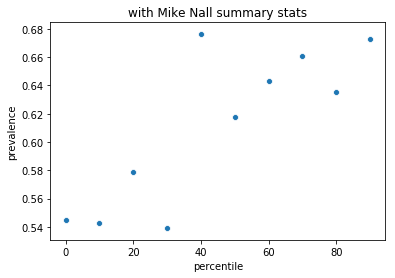

In [13]:
sub = merged_df.loc[merged_df['case_control_other_latest']!='Other']
relation = prevalence(sub,num_percentile=10,label='case_control_other_latest')
#scatter plot for prevalence in different percentile
ax = sns.scatterplot(x='percentile',y='prevalence',data=relation)
ax.set_xlabel('percentile')
ax.set_ylabel('prevalence')
ax.set_title("with Mike Nall summary stats")
ax

### Logistic Regression Prediction

newprs_overlap_MN_LDpred_p1.0000e+00.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 9)
(2995, 9)
there are 2803 samples in case and control


/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


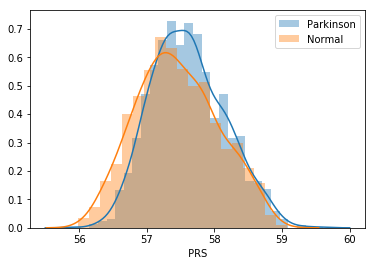

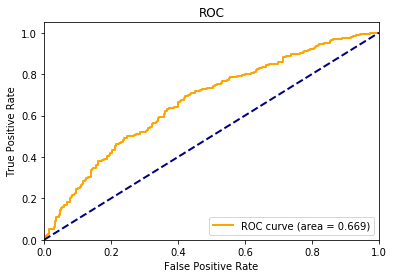

0.6421645082388615 0.6691229331416247
newprs_overlap_MN_LDpred_p3.0000e-03.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 9)
(2995, 9)
there are 2803 samples in case and control


/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


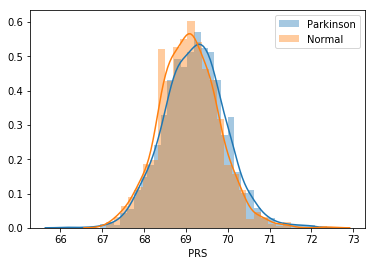

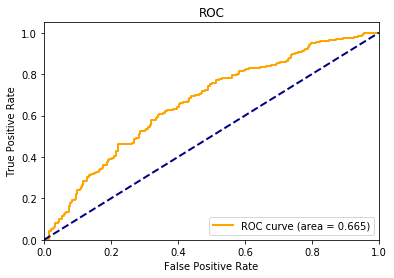

0.6286973277338227 0.6648693985142583
newprs_overlap_MN_LDpred_p3.0000e-01.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 9)
(2995, 9)
there are 2803 samples in case and control


/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


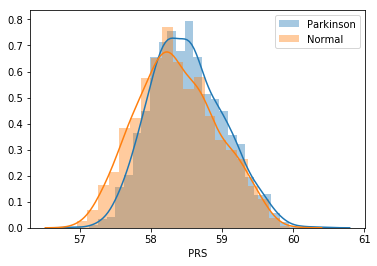

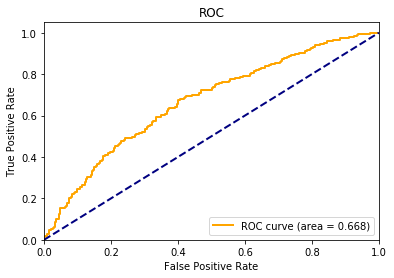

0.641369762758285 0.6678134949162987
newprs_overlap_MN_LDpred_p1.0000e-02.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 9)
(2995, 9)
there are 2803 samples in case and control


/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


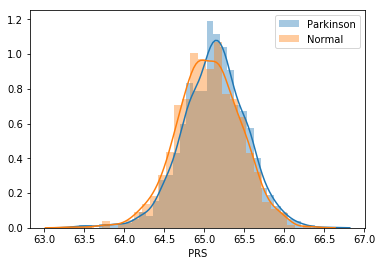

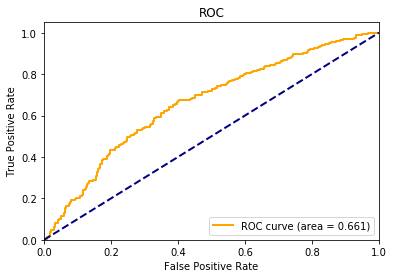

0.6257217773652993 0.6607699154428126
newprs_overlap_MN_LDpred_p1.0000e-01.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 9)
(2995, 9)
there are 2803 samples in case and control


/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


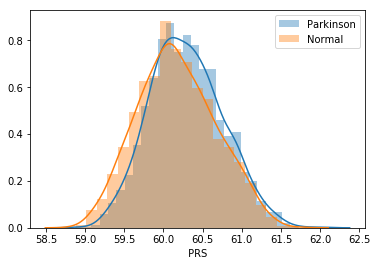

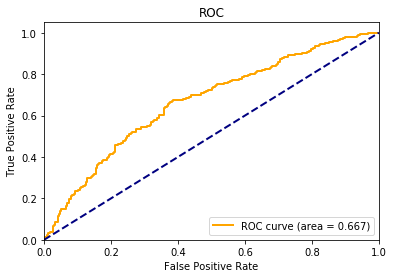

0.6389650900041979 0.6665211735305192
newprs_overlap_MN_LDpred_p3.0000e-02.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 9)
(2995, 9)
there are 2803 samples in case and control


/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


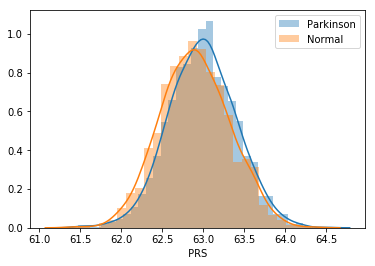

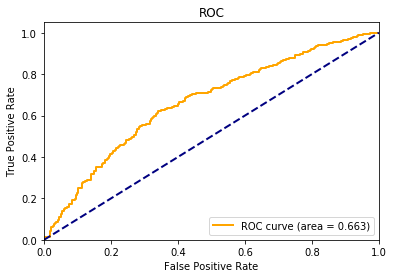

0.6320605275829083 0.6626784430522749
newprs_overlap_MN_LDpred_p1.0000e-03.txt
there are 0 missing labels
79 samples have different label at latest record with baseline
(2995, 9)
(2995, 9)
there are 2803 samples in case and control


/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


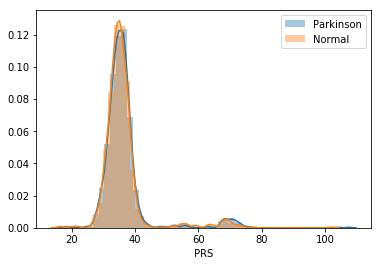

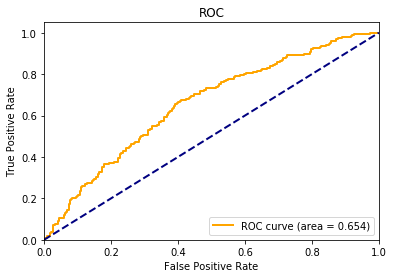

0.6158995092373878 0.6544880353291568


In [23]:
#integrate all the steps
#control_case = gcs_read_csv(os.path.join(GS_TIER1_RELEASE_PATH, 'amp_pd_case_control.csv'))
result={}
for i in glob.glob('newprs_*.txt'):#read prs file
    print(i)
    #merge with phenotype files, demographic features and family history features
    merged_df,diff_label = create_label(i,control_case,label_identity=True)
    demo_merge = merged_df.merge(demographic[['participant_id','sex','age_at_baseline']],on='participant_id',how='left')
    #feature_merged = demo_merge.merge(FH[['participant_id','biological_mother_with_pd','biological_father_with_pd','other_relative_with_pd']],on='participant_id',how='left')
    feature_merged =demo_merge
    print(feature_merged.shape)
    #feature_merged.head()
    
    ID = ['IID','participant_id']
    label = ['case_control_other_at_baseline', 'case_control_other_latest','diagnosis_latest']
    #define feature columns
    feature_column = [i for i in feature_merged.columns if (i not in ID) & (i not in label)]
    #deal with missing values and categorical features
    feature_df =  missing_value(feature_merged,feature_column)
    dummy = pd.get_dummies(feature_df[feature_column])
    df = pd.concat([feature_df[ID+label],dummy],sort=False,axis=1)
    df.drop(['sex_Male'],axis=1,inplace=True)
    print(df.shape)
    #distribution plot
    dist_plot(merged_df,score=' PRS ')
    
    #logistic regression
    dummy_feature = [i for i in df.columns if (i not in ID) & (i not in label)]
    validate_score,test_score = logisticregression(df,feature=dummy_feature,test_size=0.25,random_state=333,has_ROC=True)
    print(validate_score,test_score)
    result[i] = {'validate_score':validate_score,'test_score':test_score}

# PRS vs UPDRS

In [6]:
prs_file = 'prs_amp_p1.0000e+00.txt'
prs_notebook = 'PD_PRS'
if not os.path.exists(prs_file):
    shell_do(f'gsutil cp {Bucket}/{prs_notebook}_{data_version}/{prs_file} .')
prs = pd.read_csv(prs_file,sep='\t')
prs.head()

,IID,PRS,case_control_other_at_baseline,sex,age_at_baseline,race
0,BF-1001,57.37383,Control,Male,55,White
1,BF-1002,57.77734,Case,Female,66,White
2,BF-1003,57.02362,Case,Male,61,White
3,BF-1004,57.30569,Case,Male,62,White
4,BF-1005,57.59683,Control,Female,61,White


In [7]:
prs_casecontrol = prs.loc[prs.case_control_other_at_baseline!='Other',]
prs_casecontrol.shape

(2803, 6)

In [90]:
mds_p1 = pd.read_csv('MDS_UPDRS_Part_I.csv')
mds_p2 = pd.read_csv('MDS_UPDRS_Part_II.csv')
mds_p3 = pd.read_csv('MDS_UPDRS_Part_III.csv')

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,19,20,23,24,25,26,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [91]:
avg_mds_p1 = mds_p1.groupby(['participant_id']).mean()['mds_updrs_part_i_summary_score']
avg_mds_p1 = avg_mds_p1.rename('mds_updrs_part1_average_summary_score')
print('%d rows in mds_updrs_part1 file'%avg_mds_p1.shape[0])
bl_mds_p1 = mds_p1.loc[mds_p1.visit_name=='M0',][['participant_id','mds_updrs_part_i_summary_score']]
print('%d participants has baseline records in mds_updrs_part1 file'%bl_mds_p1.shape[0])
mds_p1 = bl_mds_p1.merge(pd.DataFrame(avg_mds_p1),right_index=True,left_on='participant_id',how='outer')
mds_p1.shape

3123 rows in mds_updrs_part1 file
3113 participants has baseline records in mds_updrs_part1 file


(3123, 3)

In [92]:
avg_mds_p2 = mds_p2.groupby(['participant_id']).mean()['mds_updrs_part_ii_summary_score']
avg_mds_p2 = avg_mds_p2.rename('mds_updrs_part2_average_summary_score')
print('%d rows in mds_updrs_part2 file'%avg_mds_p2.shape[0])
bl_mds_p2 = mds_p2.loc[mds_p2.visit_name=='M0',][['participant_id','mds_updrs_part_ii_summary_score']]
print('%d participants has baseline records in mds_updrs_part2 file'%bl_mds_p2.shape[0])
mds_p2 = bl_mds_p2.merge(pd.DataFrame(avg_mds_p2),right_index=True,left_on='participant_id',how='outer')
mds_p2.shape

3954 rows in mds_updrs_part2 file
3946 participants has baseline records in mds_updrs_part2 file


(3954, 3)

In [93]:
avg_mds_p3 = mds_p3.groupby(['participant_id']).mean()['mds_updrs_part_iii_summary_score']
avg_mds_p3 = avg_mds_p3.rename('mds_updrs_part3_average_summary_score')
print('%d rows in mds_updrs_part3 file'%avg_mds_p3.shape[0])
bl_mds_p3 = mds_p3.loc[mds_p3.visit_name=='M0',][['participant_id','mds_updrs_part_iii_summary_score']]
print('%d participants has baseline records in mds_updrs_part3 file'%bl_mds_p3.shape[0])
mds_p3 = bl_mds_p3.merge(pd.DataFrame(avg_mds_p3),right_index=True,left_on='participant_id',how='outer')
mds_p3.shape

4045 rows in mds_updrs_part3 file
4038 participants has baseline records in mds_updrs_part3 file


(4045, 3)

## PRS vs UPDRS part 1

In [118]:
df = prs.merge(mds_p1,right_on='participant_id',left_on='IID',how='inner')
df.shape

(2755, 9)

In [119]:
sum(df['mds_updrs_part_i_summary_score'].isna())

8

In [120]:
df.dropna(inplace=True)

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


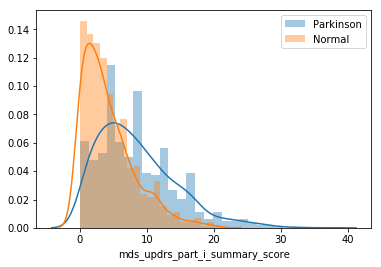

In [122]:
ax = sns.distplot((df.loc[df['case_control_other_at_baseline']=='Case'])['mds_updrs_part_i_summary_score'],label='Parkinson')
#ax = sns.distplot((merged_df.loc[(merged_df['case_control_other_latest']=='Case')&(merged_df['has_known_GBA_mutation']=='Yes')])[' PRS '],label='Parkinson&GBA')
#ax = sns.distplot((merged_df.loc[(merged_df['case_control_other_latest']=='Case')&(merged_df['has_known_GBA_mutation']=='No')])[' PRS '],label='Parkinson&non-GBA')
ax = sns.distplot((df.loc[df['case_control_other_at_baseline']=='Control'])['mds_updrs_part_i_summary_score'],label='Normal').legend()
ax

In [30]:
relation = {'updrs_1':[],'percentile':[]}
num_percentile = 10
for m in range(num_percentile):
    i = m*(100/num_percentile)
    i1 = (m+1)*(100/num_percentile)
    perc = sp.percentile(df[' PRS '],i)
    
    postperc = sp.percentile(df[' PRS '],i1)
        #print(perc,postperc)
    if i !=0:
        subdf = df.loc[((df[' PRS ']<=postperc) & (df[' PRS ']>perc))]
            #print(subdf)
    else:
        subdf = df.loc[df[' PRS ']<=postperc]
        
    #print(sum(subdf['case_control_other_latest']=='Case')/sum((subdf['case_control_other_latest']=='Case')|(subdf['case_control_other_latest']=='Control')))
    if subdf.shape[0] != 0:
        relation['percentile'].append(i)
        avg_score = np.mean(subdf['mds_updrs_part_i_summary_score'])
        relation['updrs_1'].append(avg_score)
    else:
        print('Mistake! no records in sub-dataset')

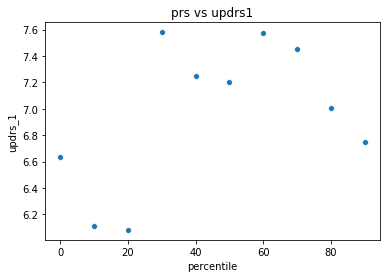

In [31]:
ax = sns.scatterplot(x='percentile',y='updrs_1',data=relation)
ax.set_xlabel('percentile')
ax.set_ylabel('updrs_1')
ax.set_title("prs vs updrs1")
ax

In [90]:
df = pd.concat([df,pd.get_dummies(df['sex'],drop_first=True)],axis=1)
X=df[[' PRS ','Male','age_at_baseline']]
y= df[['mds_updrs_part_i_summary_score']]
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=3)
lm = LinearRegression().fit(train_x,train_y)
lm.score(train_x,train_y)

0.02484165273660055

## PRS vs UPDRS part 2

In [123]:
df = prs.merge(mds_p2,right_on='participant_id',left_on='IID',how='inner')
df.shape

(2905, 9)

In [124]:
sum(df['mds_updrs_part_ii_summary_score'].isna())

159

In [125]:
df.dropna(inplace=True)

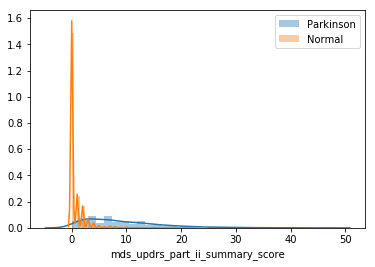

In [126]:
ax = sns.distplot((df.loc[df['case_control_other_at_baseline']=='Case'])['mds_updrs_part_ii_summary_score'],label='Parkinson')
#ax = sns.distplot((merged_df.loc[(merged_df['case_control_other_latest']=='Case')&(merged_df['has_known_GBA_mutation']=='Yes')])[' PRS '],label='Parkinson&GBA')
#ax = sns.distplot((merged_df.loc[(merged_df['case_control_other_latest']=='Case')&(merged_df['has_known_GBA_mutation']=='No')])[' PRS '],label='Parkinson&non-GBA')
ax = sns.distplot((df.loc[df['case_control_other_at_baseline']=='Control'])['mds_updrs_part_ii_summary_score'],label='Normal').legend()
ax

In [43]:
relation = {'updrs_2':[],'percentile':[]}
num_percentile = 10
for m in range(num_percentile):
    i = m*(100/num_percentile)
    i1 = (m+1)*(100/num_percentile)
    perc = sp.percentile(df[' PRS '],i)
    
    postperc = sp.percentile(df[' PRS '],i1)
        #print(perc,postperc)
    if i !=0:
        subdf = df.loc[((df[' PRS ']<=postperc) & (df[' PRS ']>perc))]
            #print(subdf)
    else:
        subdf = df.loc[df[' PRS ']<=postperc]
        
    #print(sum(subdf['case_control_other_latest']=='Case')/sum((subdf['case_control_other_latest']=='Case')|(subdf['case_control_other_latest']=='Control')))
    if subdf.shape[0] != 0:
        relation['percentile'].append(i)
        avg_score = np.mean(subdf['mds_updrs_part_ii_summary_score'])
        relation['updrs_2'].append(avg_score)
    else:
        print('Mistake! no records in sub-dataset')

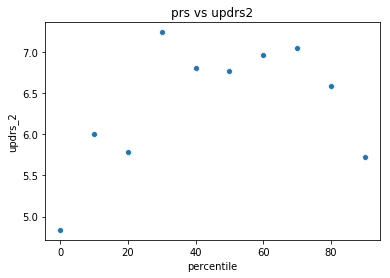

In [44]:
ax = sns.scatterplot(x='percentile',y='updrs_2',data=relation)
ax.set_xlabel('percentile')
ax.set_ylabel('updrs_2')
ax.set_title("prs vs updrs2")
ax

In [68]:
df[[' PRS ','mds_updrs_part_ii_summary_score']].corr()

,PRS,mds_updrs_part_ii_summary_score
PRS,1.000000,0.038542
mds_updrs_part_ii_summary_score,0.038542,1.000000


In [94]:
df = pd.concat([df,pd.get_dummies(df['sex'],drop_first=True)],axis=1)
X=df[[' PRS ','Male','age_at_baseline']]
y= df[['mds_updrs_part_ii_summary_score']]
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=3)
lm = LinearRegression().fit(train_x,train_y)
lm.score(train_x,train_y)

0.04561252242340108

## PRS vs UPDRS part 3

In [127]:
df = prs.merge(mds_p3,right_on='participant_id',left_on='IID',how='inner')
df.shape

(2977, 9)

In [128]:
sum(df['mds_updrs_part_iii_summary_score'].isna())

7

In [129]:
df.dropna(inplace=True)

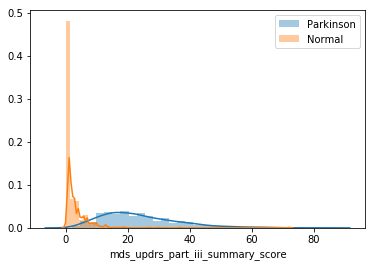

In [130]:
ax = sns.distplot((df.loc[df['case_control_other_at_baseline']=='Case'])['mds_updrs_part_iii_summary_score'],label='Parkinson')
#ax = sns.distplot((merged_df.loc[(merged_df['case_control_other_latest']=='Case')&(merged_df['has_known_GBA_mutation']=='Yes')])[' PRS '],label='Parkinson&GBA')
#ax = sns.distplot((merged_df.loc[(merged_df['case_control_other_latest']=='Case')&(merged_df['has_known_GBA_mutation']=='No')])[' PRS '],label='Parkinson&non-GBA')
ax = sns.distplot((df.loc[df['case_control_other_at_baseline']=='Control'])['mds_updrs_part_iii_summary_score'],label='Normal').legend()
ax

In [58]:
relation = {'updrs_3':[],'percentile':[]}
num_percentile = 10
for m in range(num_percentile):
    i = m*(100/num_percentile)
    i1 = (m+1)*(100/num_percentile)
    perc = sp.percentile(df[' PRS '],i)
    
    postperc = sp.percentile(df[' PRS '],i1)
        #print(perc,postperc)
    if i !=0:
        subdf = df.loc[((df[' PRS ']<=postperc) & (df[' PRS ']>perc))]
            #print(subdf)
    else:
        subdf = df.loc[df[' PRS ']<=postperc]
        
    #print(sum(subdf['case_control_other_latest']=='Case')/sum((subdf['case_control_other_latest']=='Case')|(subdf['case_control_other_latest']=='Control')))
    if subdf.shape[0] != 0:
        relation['percentile'].append(i)
        avg_score = np.mean(subdf['mds_updrs_part_iii_summary_score'])
        relation['updrs_3'].append(avg_score)
    else:
        print('Mistake! no records in sub-dataset')

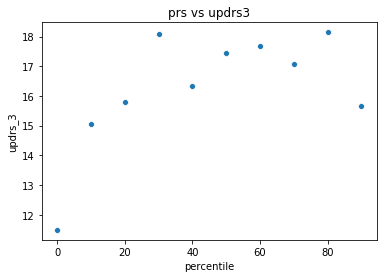

In [59]:
ax = sns.scatterplot(x='percentile',y='updrs_3',data=relation)
ax.set_xlabel('percentile')
ax.set_ylabel('updrs_3')
ax.set_title("prs vs updrs3")
ax

In [72]:
df[[' PRS ','mds_updrs_part_iii_summary_score']].corr()

,PRS,mds_updrs_part_iii_summary_score
PRS,1.000000,0.070138
mds_updrs_part_iii_summary_score,0.070138,1.000000


In [98]:
df = pd.concat([df,pd.get_dummies(df['sex'],drop_first=True)],axis=1)
X=df[[' PRS ','Male','age_at_baseline']]
y= df[['mds_updrs_part_iii_summary_score']]
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=3)
lm = LinearRegression().fit(train_x,train_y)
lm.score(train_x,train_y)

0.09306803331657976

# Provenance

In [1]:
import datetime
print(datetime.datetime.now())

2020-01-22 18:36:50.527475


In [2]:
!pip3 freeze

cloudpickle==1.2.2
cmapPy==4.0.1
cruzdb==0.5.6
dcor==0.3
dill==0.3.1.1
google-api-core==1.14.3
google-auth-oauthlib==0.4.1
google-cloud-bigquery==1.23.1
google-cloud-core==1.1.0
google-pasta==0.1.8
hickle==3.4.5
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.0
llvmlite==0.30.0
numba==0.46.0
numpy==1.17.4
oauthlib==3.1.0
opt-einsum==3.1.0
pandas-gbq==0.13.0
plinkio==0.9.7
pydata-google-auth==0.2.1
pyplink==1.3.5
requests-oauthlib==1.3.0
scikit-learn==0.22
tensorboard==2.0.1
tensorflow==2.0.0
tensorflow-estimator==2.0.1
umap-learn==0.3.10
